In [1]:
# DEBUG: check executable
# import sys
# sys.executable

In [1]:
import librosa # library audio analysis
import numpy as np
import IPython
from IPython.display import display, Audio # visualization
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

In [2]:
print(tf.__version__)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
tf.compat.v1.enable_eager_execution()

print("Executing eagerly?", tf.executing_eagerly())

print("GPU:", tf.config.list_physical_devices('GPU'))

2.10.1
Executing eagerly? True
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
#declare global variables
TRAIN_SET_DIR = os.path.join('..', 'archive','TRAIN_V2','data_out_2')
RANDOM_SEED = 42
VALIDATION_RATE = 0.1
FREQ_CAP = 7000
SAMPLING_RATE = 5512
SAMPLING_LENGTH = 27  # seconds
MEL_DETAIL = 64
BATCH_SIZE = 64
EPOCHS = 20

In [4]:
#create array to store all the training song paths
song_paths = []
unique_genre_nums = os.listdir(TRAIN_SET_DIR);
song_genre_nums = []

# loop over each music genre
for genre_num in unique_genre_nums:
    
    # in each music genre, add the paths of all the music to the array
    for song_path in os.listdir(os.path.join(TRAIN_SET_DIR, genre_num)):
        song_paths.append(os.path.join(TRAIN_SET_DIR, genre_num, song_path))
        song_genre_nums.append(int(genre_num))

In [5]:
# convert both of these to np arrays for efficiency
song_paths = np.array(song_paths)
song_genre_nums = np.array(song_genre_nums)

# suffle both arrays with the same shuffle seed
np.random.seed(RANDOM_SEED)
np.random.shuffle(song_paths)
np.random.shuffle(song_genre_nums)

# split both into training and testing sets
num_songs = len(song_genre_nums)
num_validation = int(num_songs * VALIDATION_RATE)

validation_genres = song_genre_nums[-num_validation :]
validation_paths = song_paths[-num_validation :]

training_genres = song_genre_nums[: -num_validation]
training_paths = song_paths[: -num_validation]

print("number of validations")
print(len(validation_genres))
print('number of trainings')
print(len(training_paths))

number of validations
1990
number of trainings
17914


In [6]:
def create_dataset(audio_paths, audio_classes):
    
    # create zip dataset
    ds = tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(audio_paths),
            tf.data.Dataset.from_tensor_slices(audio_classes)
        )
    ).prefetch(tf.data.AUTOTUNE)
    
    # REMOVED due to performance overhead
    # exclude short tracks (garbage data) from the dataset
    # ds = ds.filter(lambda x, y: tf.py_function(
    #     exclude_short_tracks, [x, y], tf.bool))
    
    # map each path to a spectrogram
    # contains the mel from all sources' first [SAMPLING_LENGTH] seconds.
    ds = ds.map(
        lambda x, y: (tf.py_function(make_mel, [x], tf.float32), y),
        num_parallel_calls = tf.data.AUTOTUNE
    ).batch(BATCH_SIZE)
    # print(ds)
    
    return ds

# return true only if the file is longer than SAMPLING_LENGTH
def exclude_short_tracks(path, label):
    path = path.numpy().decode('ascii')
    # print("==========THIS IS MY DATA:", path, label)
    # print("path:", path)
    length = librosa.get_duration(path = path)
    # print("length:",length)
    return length > SAMPLING_LENGTH

# get path, read audio data, pass it into next func to get mel, then return it
# this will be used in map (look above)
def make_mel(path):
    # the first x seconds of the track are imported
    path = path.numpy().decode('ascii')
    
    audio_data, _ = librosa.load(
        path, sr = SAMPLING_RATE, duration = SAMPLING_LENGTH
    )
    mel = librosa.feature.melspectrogram(
        y = audio_data, sr = SAMPLING_RATE, n_mels = MEL_DETAIL, fmax = FREQ_CAP
    )

    # EXPERIMENTAL: expand dimensions so you have 4
    mel = tf.expand_dims(mel, axis = 2)
    
    return mel

In [7]:
#convert path and class arrays to dataset...
train_ds = create_dataset(training_paths, training_genres)
valid_ds = create_dataset(validation_paths, validation_genres)

# DEBUG: check the cardinality of resulting dataset
# print("Training dataset cardinality:", train_ds.reduce(0, lambda x, _: x + 1).numpy())
# print("Validation dataset cardinality:", valid_ds.reduce(0, lambda x, _: x + 1).numpy())

..\archive\TRAIN_V2\data_out_2\6\9560.wav


C:\Users\ashka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\feature\spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


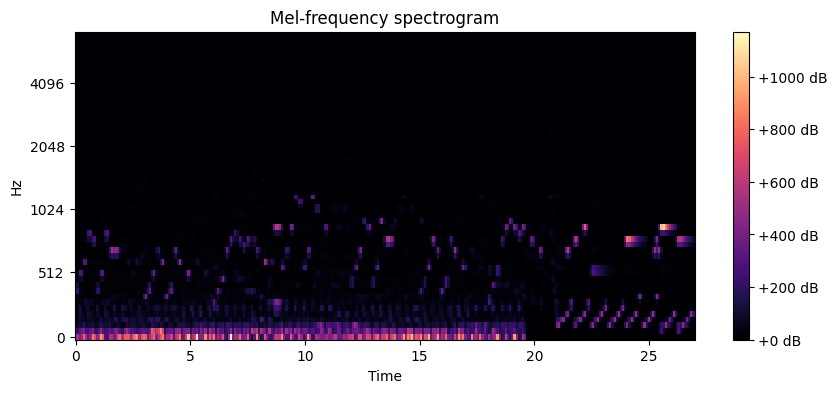

None

..\archive\TRAIN_V2\data_out_2\0\21725.wav


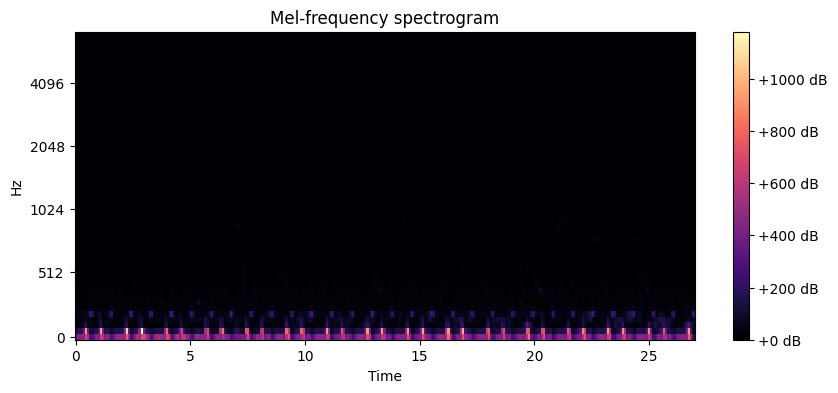

None

..\archive\TRAIN_V2\data_out_2\0\16748.wav


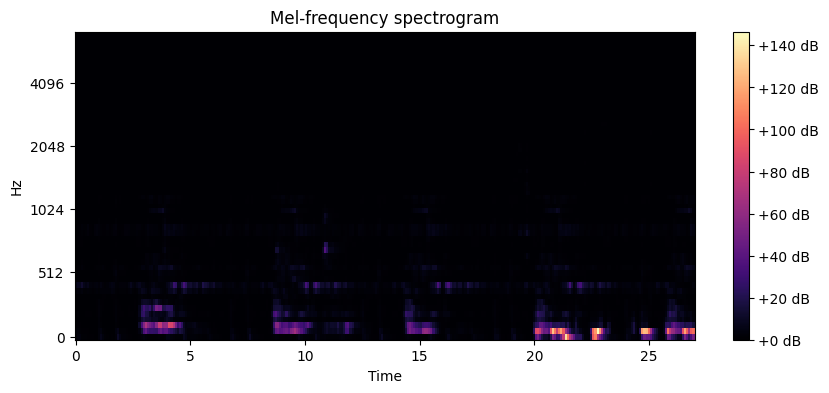

None

..\archive\TRAIN_V2\data_out_2\3\19206.wav


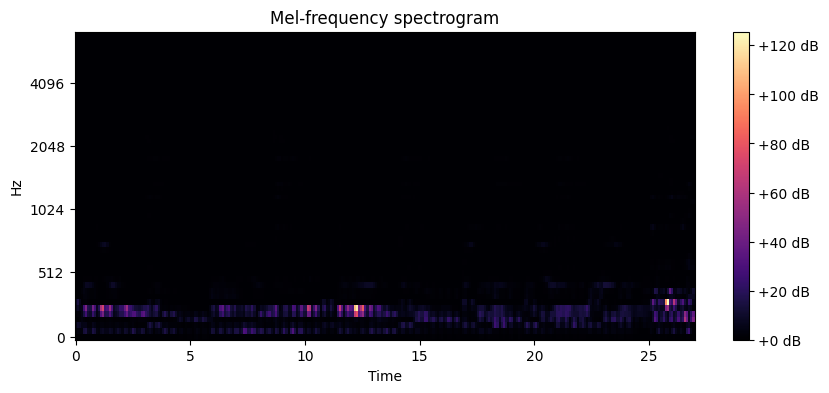

None

In [10]:
# VISUALIZATION
def visualize_audio(path):
    print(path)
    
    display(Audio(path))
    
    audio_data, _ = librosa.load(
        path, sr = SAMPLING_RATE, duration = SAMPLING_LENGTH
    )
    mel = librosa.feature.melspectrogram(
        y = audio_data, sr = SAMPLING_RATE, n_mels = MEL_DETAIL, fmax = FREQ_CAP
    )
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=SAMPLING_RATE, fmax = FREQ_CAP)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    display(plt.show())

visualize_audio(training_paths[1245])
visualize_audio(training_paths[5271])
visualize_audio(training_paths[16])
visualize_audio(training_paths[11666])

In [10]:
# Ashkan's model
class CNN(keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(CNN, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv = layers.Conv2D(filters, kernel_size)
        self.normalization = layers.ReLU()
        self.pooling = layers.MaxPool2D()

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
        })
        return config

    def call(self, input):
        # print("=====================\n",input)
        x = self.conv(input)
        x = self.normalization(x)
        x = self.pooling(x)
        return x

model = keras.Sequential()

# convolutional layers
model.add(CNN(32, 3))
model.add(CNN(64, 3))
model.add(CNN(128, 3))

# flatten
model.add(layers.Flatten())

# dense layers
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
# model.add(layers.Dense(19, activation = 'softmax')) # REVERT to softmax activation (from_logits won't work)
model.add(layers.Dense(19, activation = 'linear'))

# compile
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer = 'adam', metrics = ['accuracy'])

# CHANGES BEFORE FINAL BUILD
# set epochs to 20


In [ ]:
# testing Ashkan's model

# fit
model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE
)

# DO NOT RESTART THE KERNEL --> loaded data will be lost


Epoch 1/20
280/280 [==============================] - 685s 2s/step - loss: 3.0930 - accuracy: 0.1444
Epoch 2/20
280/280 [==============================] - 702s 3s/step - loss: 2.5245 - accuracy: 0.1576
Epoch 3/20
280/280 [==============================] - 1005s 4s/step - loss: 2.4829 - accuracy: 0.1801
Epoch 4/20
 86/280 [========>.....................] - ETA: 15:50 - loss: 2.4488 - accuracy: 0.1966

In [ ]:
# evaluate
model.evaluate(valid_ds, batch_size = BATCH_SIZE)

In [ ]:
# save model
model.save('models/mel2-ash-FULL.keras')

In [ ]:
# # load model to see if it evaluates
# saved_model = keras.models.load_model('models/mel2-ash-partial.keras', custom_objects = {'CNN': CNN})
# saved_model.evaluate(valid_ds, batch_size = BATCH_SIZE)